# Motivating example

Generates the figure 1 of the paper. Takes as input the set of illustration images from Fel et al [1](),[2]() and their corrupted counterparts, corrupted from [3](). 

Returns the predictions, and the consistency of the predictions. Then plots the predictinos and various explanability methods to show that traditional methods cannot fail to:
* (1) Provide informative explanations 
* <b> (2) Provide insights on why the model failed to accurately predict the label under the given shift </b>

While the failure to provide informative explanation has been studied by earlier works [4](), our focus will be on explaining why a model fails to predict the label under given shifts, leveraging the Wavelet attribution method. 

In [1]:
# Libraries and imports
import sys
sys.path.append('../')

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from src import datasets, utils
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F
from PIL import Image
from torchvision.models import resnet50
import tqdm
import torch
from spectral_sobol.torch_explainer import WaveletSobol, SobolAttributionMethod
#from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
#from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

2023-04-13 10:56:07.641089: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 10:56:08.288519: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Inference of the model

In [59]:
# load the model and the data
device = 'cuda'

batch_size = 256

model = resnet50(pretrained = True)

df = pd.read_csv("labels_example.csv")
df = df[['name', "label"]]

source = "imgs/"
# corrupted = 'imgs-c/' # create the corrupted images on the fly
corruptions = os.listdir(corrupted)

# some images have not been converted
remaining_images = os.listdir(os.path.join(corrupted, corruptions[0]))

df = df[df['name'].isin(remaining_images)]
print(df.shape)

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.CenterCrop(224),
    #torchvision.transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
    #torchvision.transforms.RandomRotation((-90,-90))
])

dataloaders = {}

dataset = datasets.ImageNetDataset(df, source, transform=transforms)
dataloaders['source'] = DataLoader(dataset, batch_size = batch_size)

for corruption in os.listdir(corrupted):

    folder = os.path.join(corrupted, corruption)
    dataset = datasets.ImageNetDataset(df, folder, transform = transforms)
    dataloaders[corruption] = DataLoader(dataset, batch_size = batch_size)

(10, 2)


In [60]:
# inference
device = 'cuda'
model.to(device)


# matrix that stores all predictions
predictions = np.zeros((df.shape[0], len(dataloaders.keys())))

raw_out = {}

with torch.no_grad():

    for i, c in enumerate(list(dataloaders.keys())): # loop over the corruptions

        data  = dataloaders[c]
        tmp_preds = []
        names = []

        for d in tqdm.tqdm(data):

            images, labels, name = d
            # move the images to the device
            images = images.to(device)

        
            # calculate outputs by running images through the network and computing the prediction using the threshold
            outputs = model(images)
            preds = torch.argmax(F.softmax(outputs, dim = 1), dim = 1).cpu().detach().numpy()
            tmp_preds.append(list(preds))
            names.append(name)

            raw_out[c] = outputs

        tmp_preds = list(sum(tmp_preds, []))
        tmp_preds = np.array(tmp_preds)
        names = list(sum(names, ()))

        predictions[:,i] = tmp_preds


100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


In [61]:
preds = {n : p.astype(int) for (n,p) in zip(names, predictions[:,0])}
classes = {
 'fox.png': 278,
 'snow_fox.png': 279,
 'polar_bear.png': 296,
 'leopard.png': 288,
 'fox1.jpg': 277,
 'fox2.jpg': 277,
 'sea_turtle.jpg': 33,
 'lynx.jpg': 287,
 'cat.jpg': 281,
 'otter.jpg': 360
}

outs = {}
for n in classes.keys():
    p, r  = preds[n], classes[n]

    outs[n] = (p, r)

# mispredictes : fox.png, fox2.jpg, sea_turtle.jpg
outs

{'fox.png': (277, 278),
 'snow_fox.png': (279, 279),
 'polar_bear.png': (296, 296),
 'leopard.png': (288, 288),
 'fox1.jpg': (277, 277),
 'fox2.jpg': (161, 277),
 'sea_turtle.jpg': (787, 33),
 'lynx.jpg': (287, 287),
 'cat.jpg': (281, 281),
 'otter.jpg': (360, 360)}

In [70]:
df

name  label
0        fox2.jpg    277
1    snow_fox.png    279
2         fox.png    278
3         cat.jpg    281
4     leopard.png    288
5  polar_bear.png    296
6  sea_turtle.jpg     33
7        fox1.jpg    277
8       otter.jpg    360
9        lynx.jpg    287

## Generate explanations across corruptions

We now consider a set of explanations and generate explanations for the different 

In [2]:
img_name = "cat.jpg"
device = 'cuda'
model = resnet50(pretrained = True).to(device)

classes = {
 'fox.png': 278,
 'snow_fox.png': 279,
 'polar_bear.png': 296,
 'leopard.png': 288,
 'fox1.jpg': 277,
 'fox2.jpg': 277,
 'sea_turtle.jpg': 33,
 'lynx.jpg': 287,
 'cat.jpg': 281,
 'otter.jpg': 360
}

img = Image.open('../assets/{}'.format(img_name))

# transforms
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

preprocessing = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize,
])

x = torch.stack(
    [preprocessing(img)]
).to(device)

y = np.array([classes[img_name]])

variants = []

for i in [2,4,8,16,32]:
    print('testing with i = {}'.format(i))
    wavelet = WaveletSobol(model, grid_size = 28, nb_design = i, batch_size = 128)
    variants.append(wavelet(x,y))

testing with i = 2
testing with i = 4
testing with i = 8
testing with i = 16
testing with i = 32


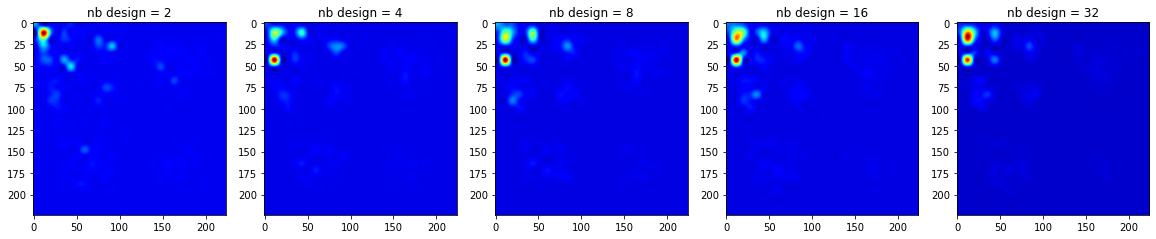

In [7]:

from utils import helpers

fig, ax = plt.subplots(1,5, figsize = (20,4))

for i in range(len(variants)):

    ax[i].set_title('nb design = {}'.format(2**(i + 1)))
    ax[i].imshow(variants[i][0], cmap = 'jet')
    #helpers.add_lines(224, 3, ax[i])


plt.show()

In [109]:
sobol = SobolAttributionMethod(model, batch_size = 128)

# pick some images to generate examples
# images are taken across image name and perturbation 
# we consider the explanation on the source and the explanation 
# on the targets 

index = -2

model = model.to(device)

img_name, label = df.iloc[index]['name'], df.iloc[index]['label']

image_set = [Image.open(os.path.join(source, img_name)).convert('RGB')]
for c in corruptions:
    target = os.path.join(corrupted, c)
    image_set.append(Image.open(os.path.join(target, img_name)).convert("RGB"))

x = torch.stack([
    transforms(im) for im in image_set
]).to(device)
y = predictions[index, :].astype(int)

explanations = sobol(x,y)



# wb explanations
target_layers = [model.layer4[-1]]
# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
campp = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)

targets = [ClassifierOutputTarget(c) for c in y]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
cams = cam(input_tensor=x, targets=targets, aug_smooth = True)
cams_pp = campp(input_tensor=x, targets=targets, aug_smooth = True)

# wavelet cam 
# remove the approximation coefficients
# set the option to remove the approximation coefficients from the computation
wavelet = WaveletSobol(model, grid_size = 28, nb_design = 2, batch_size = 128, opt = {"approximation" : False})
wavel_expl = wavelet(x,y)


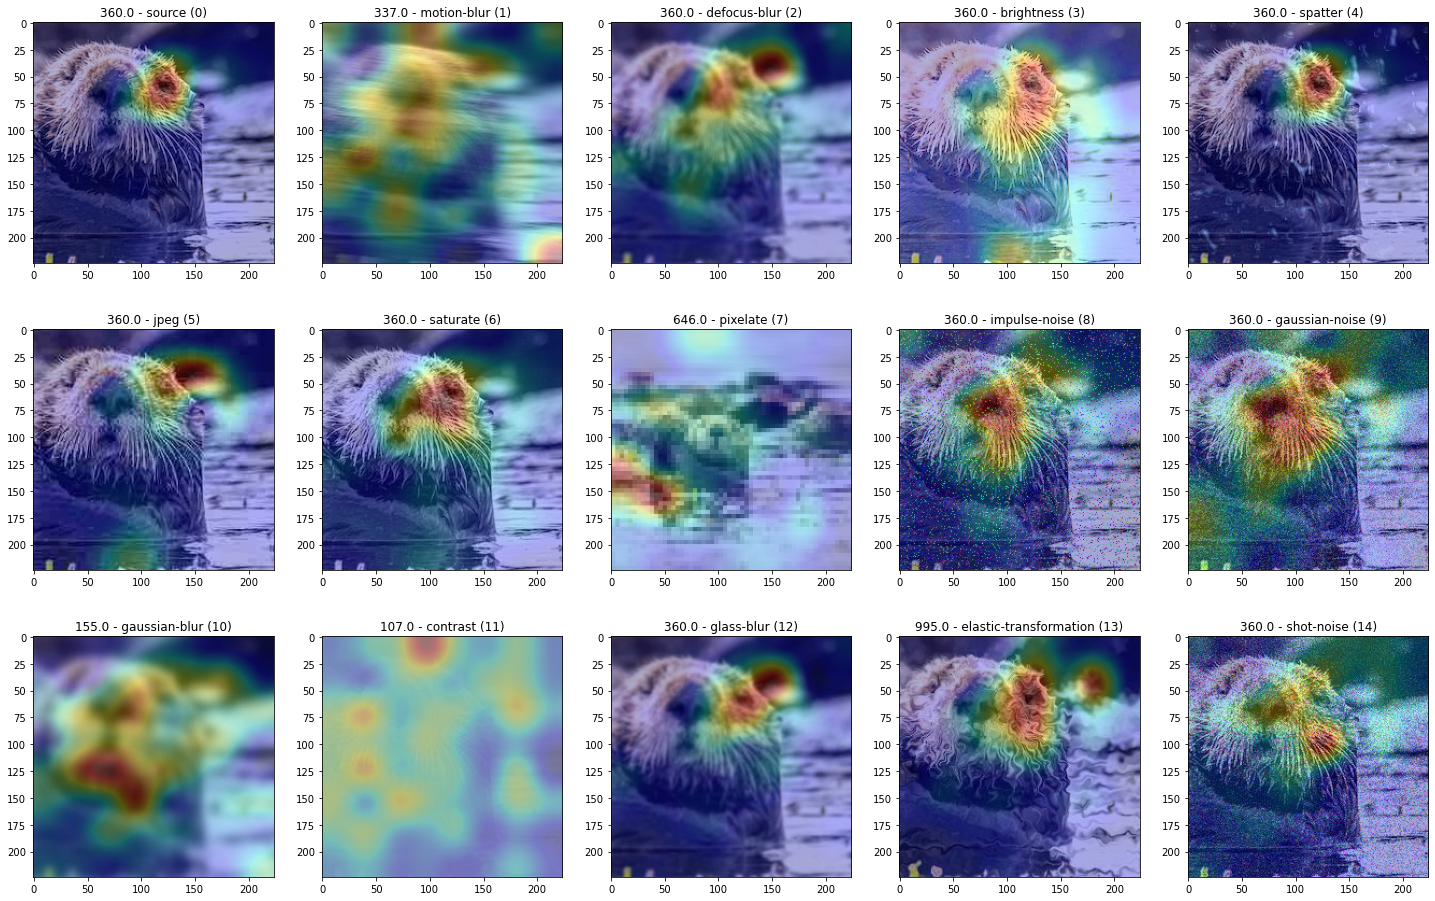

In [110]:
# find some interesting cases
# the failure of attribution methods to identify why the model failed
# to predict the class correctly due to distribution shift

fig, ax = plt.subplots(3,5, figsize = (25,16))

# corruption_names = list(dataloaders.keys())
# 
# for i,c,in (enumerate([0,5,9,14])): # first row: the raw image with corruption
# 
#     ax[0,i].set_title(corruption_names[c])
#     ax[0,i].imshow(np.rot90(x[c].cpu().detach().numpy().swapaxes(0,-1), k = -1))
# 
# plt.show()

row = -1

for i, expl in enumerate(explanations):

    c = list(dataloaders.keys())[i]

    if i % 5 == 0:
        row += 1

    dat = x[i].cpu().detach().numpy().swapaxes(0,-1)

    ax[row, i%5].imshow(np.rot90(dat, k = -1))
    ax[row, i%5].set_title('{} - {} ({})'.format(predictions[index,i], c, i))
    ax[row, i%5].imshow(expl, cmap = 'jet', alpha = 0.3)

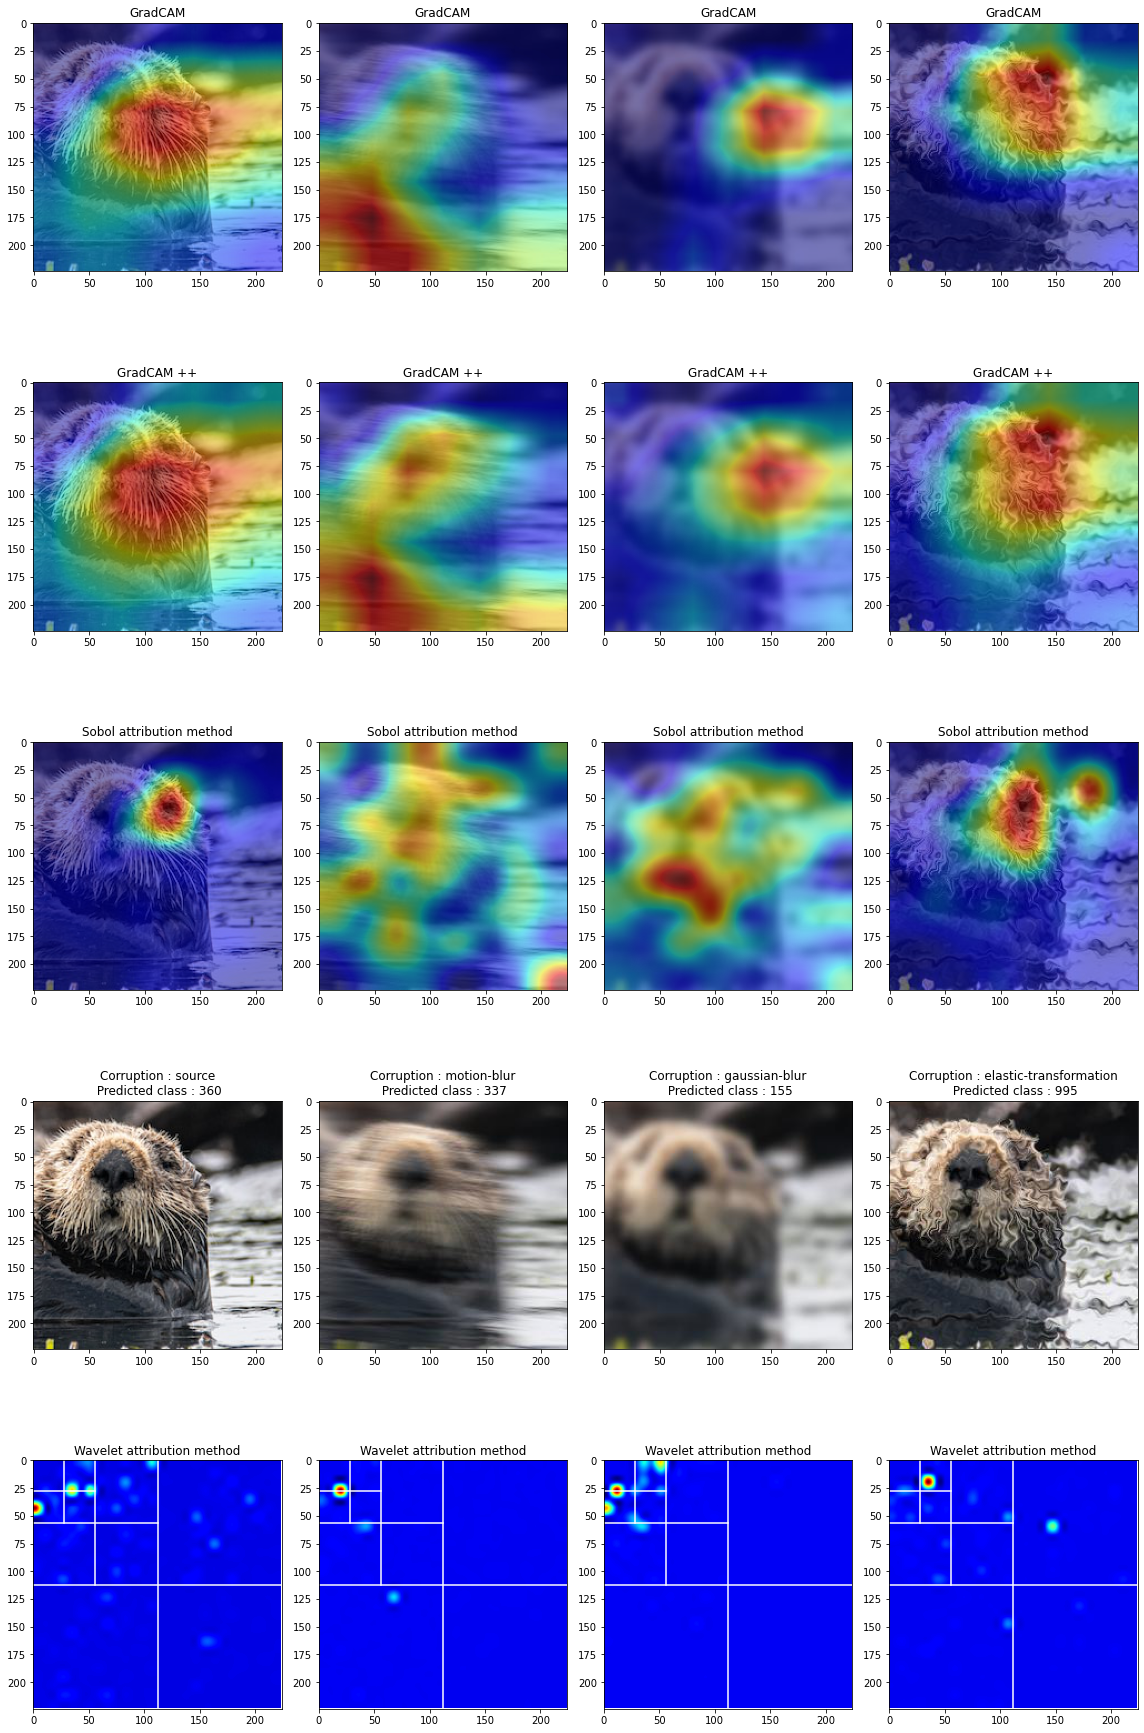

In [111]:
# main plot
# the failure of attribution methods to identify why the model failed
# to predict the class correctly due to distribution shift

fig, ax = plt.subplots(5,4, figsize = (16,25))

corruption_names = list(dataloaders.keys())
targets = [0, 1, 10, 13] # change here depending on the interesting corruption cases

for i,c,in (enumerate(targets)): # first row: the raw image with corruption


    title = "Corruption : {}\n Predicted class : {}".format(corruption_names[c], y[c])
    ax[3,i].set_title(title)
    ax[3,i].imshow(np.rot90(x[c].cpu().detach().numpy().swapaxes(0,-1), k = -1))

    # also plot it for the subsequent rows
    ax[0,i].imshow(np.rot90(x[c].cpu().detach().numpy().swapaxes(0,-1), k = -1))
    ax[1,i].imshow(np.rot90(x[c].cpu().detach().numpy().swapaxes(0,-1), k = -1))
    ax[2,i].imshow(np.rot90(x[c].cpu().detach().numpy().swapaxes(0,-1), k = -1))


# now plot the explanation methods
for i,t in enumerate(targets):
    att_cam = cams[t]
    att_campp = cams_pp[t]
    att_sobol = explanations[t]
    att_wav = wavel_expl[t]

    ax[0,i].imshow(att_cam, cmap = 'jet', alpha = 0.5)
    ax[0,i].set_title('GradCAM')
    ax[1,i].imshow(att_campp, cmap = 'jet', alpha = 0.5)
    ax[1,i].set_title('GradCAM ++')
    ax[2,i].imshow(att_sobol, cmap = 'jet', alpha = 0.5)
    ax[2,i].set_title('Sobol attribution method')


    ax[4,i].set_title('Wavelet attribution method')
    ax[4,i].imshow(att_wav, cmap = 'jet')
    utils.add_lines(224, 3, ax[4,i])

fig.tight_layout()
plt.savefig('figs/motivation_plot-3.pdf')
plt.show()

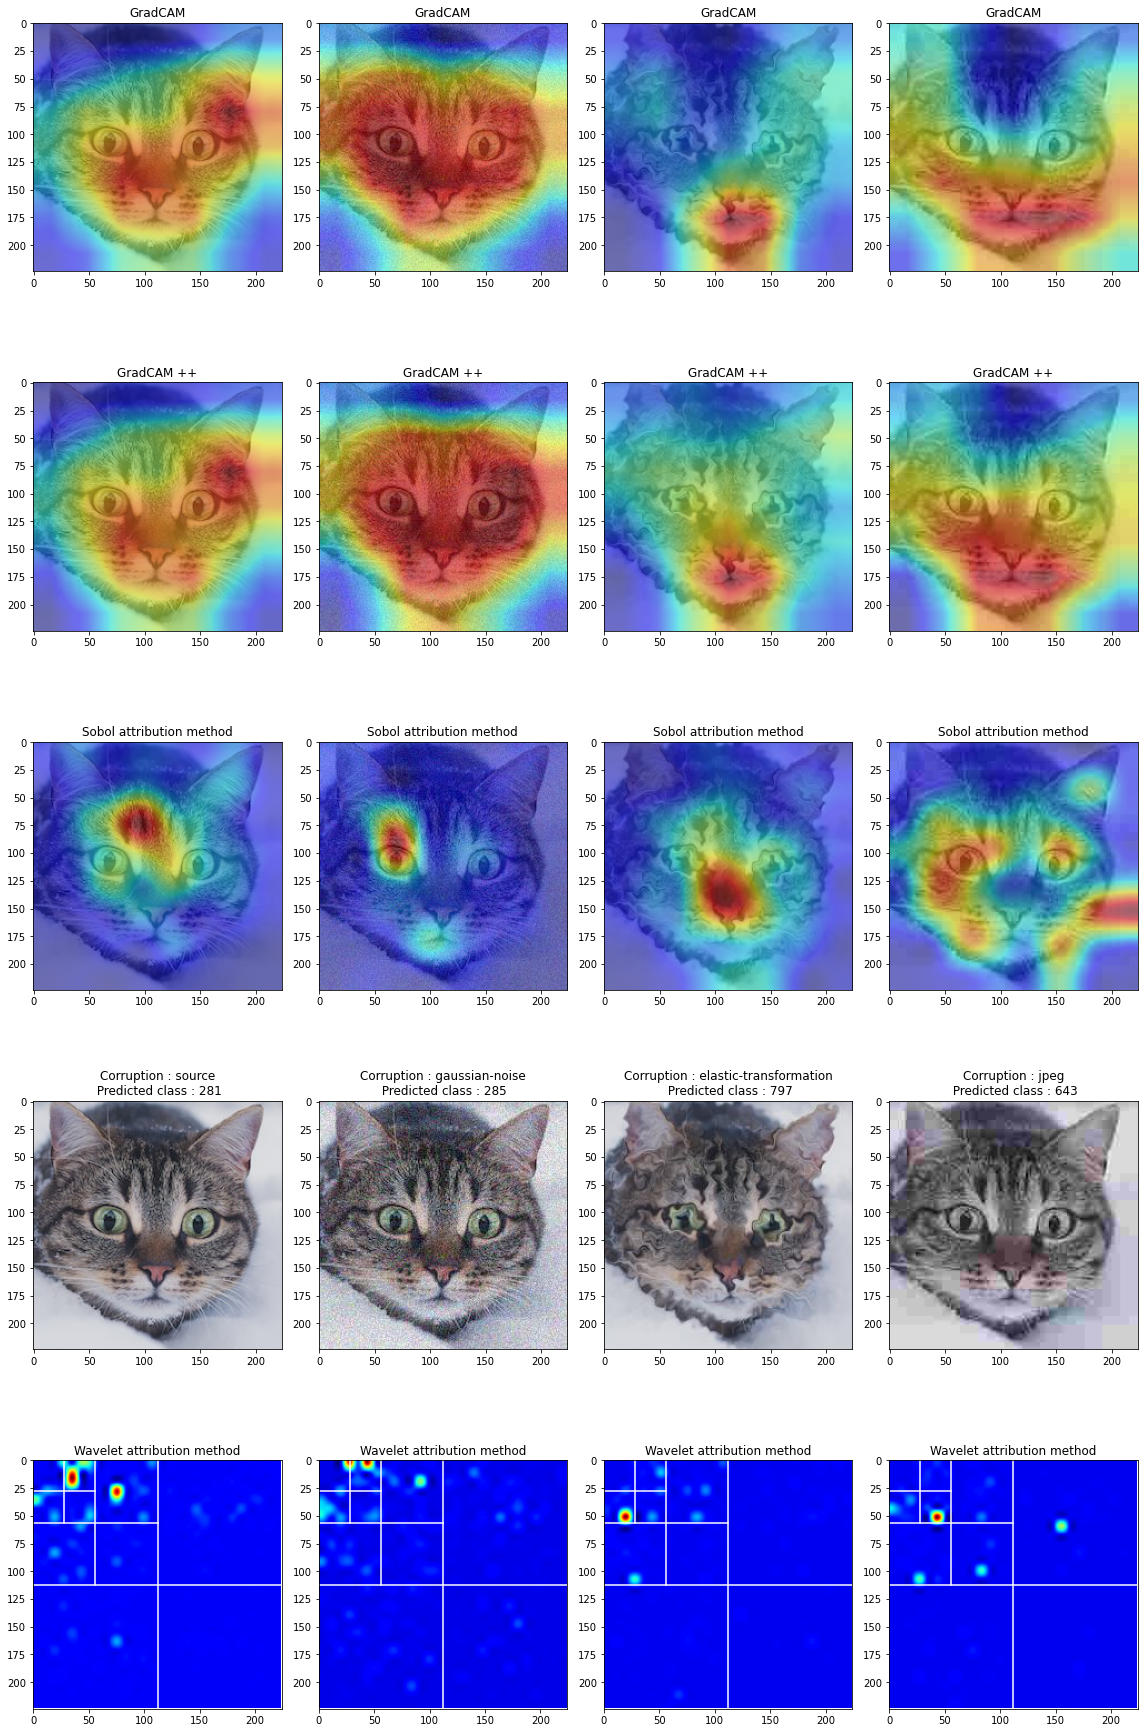

In [102]:
# main plot
# the failure of attribution methods to identify why the model failed
# to predict the class correctly due to distribution shift

fig, ax = plt.subplots(5,4, figsize = (16,25))

corruption_names = list(dataloaders.keys())
targets = [0, 9, 13, 5] # change here depending on the interesting corruption cases

for i,c,in (enumerate(targets)): # first row: the raw image with corruption


    title = "Corruption : {}\n Predicted class : {}".format(corruption_names[c], y[c])
    ax[3,i].set_title(title)
    ax[3,i].imshow(np.rot90(x[c].cpu().detach().numpy().swapaxes(0,-1), k = -1))

    # also plot it for the subsequent rows
    ax[0,i].imshow(np.rot90(x[c].cpu().detach().numpy().swapaxes(0,-1), k = -1))
    ax[1,i].imshow(np.rot90(x[c].cpu().detach().numpy().swapaxes(0,-1), k = -1))
    ax[2,i].imshow(np.rot90(x[c].cpu().detach().numpy().swapaxes(0,-1), k = -1))


# now plot the explanation methods
for i,t in enumerate(targets):
    att_cam = cams[t]
    att_campp = cams_pp[t]
    att_sobol = explanations[t]
    att_wav = wavel_expl[t]

    ax[0,i].imshow(att_cam, cmap = 'jet', alpha = 0.5)
    ax[0,i].set_title('GradCAM')
    ax[1,i].imshow(att_campp, cmap = 'jet', alpha = 0.5)
    ax[1,i].set_title('GradCAM ++')
    ax[2,i].imshow(att_sobol, cmap = 'jet', alpha = 0.5)
    ax[2,i].set_title('Sobol attribution method')


    ax[4,i].set_title('Wavelet attribution method')
    ax[4,i].imshow(att_wav, cmap = 'jet')
    utils.add_lines(224, 3, ax[4,i])

fig.tight_layout()
plt.savefig('figs/motivation_plot.pdf')
plt.show()